In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
from scipy import stats
import plotly.subplots as sp
import plotly.graph_objects as go
import scipy.stats as sts
import statsmodels.graphics.gofplots as sm

df = pd.read_excel("BakeryData_Vilnius.xlsx")
stores = ["main street A","main street B","station A","station B"]
daysOfTheWeek = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["weekday_text"] = df['date'].dt.strftime('%A')
df["date"] = pd.to_datetime(df["date"]).dt.date
df

,date,weekday,main street A,main street B,station A,station B,weekday_text
0,2016-05-11,3,2.23,NaN,NaN,NaN,Wednesday
1,2016-05-12,4,18.10,NaN,NaN,NaN,Thursday
2,2016-05-13,5,15.85,NaN,NaN,NaN,Friday
3,2016-05-14,6,14.22,NaN,NaN,NaN,Saturday
4,2016-05-15,7,2.58,NaN,NaN,NaN,Sunday
...,...,...,...,...,...,...,...
2572,2023-05-27,6,168.05,32.34,76.97,114.30,Saturday
2573,2023-05-28,7,44.62,32.85,80.21,91.25,Sunday
2574,2023-05-29,1,64.11,116.84,149.75,92.56,Monday
2575,2023-05-30,2,103.63,134.48,194.03,75.63,Tuesday


In [2]:
pre_covid = datetime(day = 1,month = 3,year = 2021).date()
after_covid = datetime(day = 1,month = 3,year = 2022).date()
df = df[(df["date"] < pre_covid) | (df["date"] > after_covid)]

In [3]:
class Store():
    def __init__(self, name, p, pl, c, cs):
        self.name = name
        self.p = p
        self.pl = pl
        self.c = c
        self.cs = cs
    def feature(self, day):
        feature = df[df["weekday_text"] == day][self.name]
        feature = feature[~np.isnan(feature)]
        return feature
    def nonParametricOptimalInterval(self, day, alpha):
        feature = self.feature(day)
        criticalValue = ((self.p-self.c)/(self.p + self.cs - self.pl))
        criticalAmount = feature.quantile(criticalValue)
        z = 1 / sts.norm.ppf(1-alpha/2)
        feature = np.sort(feature)
        n = len(feature)
        deviation = (z * np.sqrt(n*criticalValue * (1-criticalValue)))
        upperBound = int(n*criticalValue + deviation)
        lowerBound = int(n*criticalValue - deviation)
        if upperBound > n:
            upperBound = n
        if lowerBound < 1:
            lowerBound = 1
        minimumAmount, maximumAmount  = feature[lowerBound - 1], feature[upperBound - 1]
        return {'optimalQuantity': criticalAmount, 'lower bound': minimumAmount, 'upper bound': maximumAmount}
    def parametricOptimalInterval(self, day, alpha):
        feature = self.feature(day)
        overage_cost = self.p - self.c
        underage_cost = self.c + self.cs - self.pl
        quantile = overage_cost / ( overage_cost + underage_cost)
        optimalQuantity = sts.norm.ppf(quantile, loc=np.mean(feature), scale=np.std(feature))

        nonParametricOptimalQuantity = self.nonParametricOptimalInterval(day,alpha)["optimalQuantity"]
        z = sts.norm.ppf(1-alpha/2)
        n = len(feature)
        sd = np.std(feature)
        minimumAmount = nonParametricOptimalQuantity - z * sd / np.sqrt(n)
        maximumAmount = nonParametricOptimalQuantity + z * sd / np.sqrt(n)
        return {'optimalQuantity': optimalQuantity, 'lower bound': minimumAmount, 'upper bound': maximumAmount}

mainstreetA = Store("main street A", 4.64, 0.15, 3.85, 0.11)
mainstreetB = Store("main street A", 4.64, 0.15, 3.42, 0.08)
stationA = Store("station A", 4.64, 0.15, 4.16, 0.08)
stationB = Store("station B", 4.64, 0.15, 3.32, 0.09)

Stores = [mainstreetA, mainstreetB, stationA, stationB]

print(stationA.nonParametricOptimalInterval("Sunday",0.05))
print(stationA.parametricOptimalInterval("Sunday",0.05))


{'optimalQuantity': 65.02938730853391, 'lower bound': 63.52, 'upper bound': 65.17}
{'optimalQuantity': 65.0470134842399, 'lower bound': 63.90349744413421, 'upper bound': 66.15527717293362}


Jarque–Bera Testing method for normality

In [13]:
alpha = 0.05
table = []
for store in stores:
    for day in daysOfTheWeek:
        data = np.log(df[df["weekday_text"] == day][store].dropna())
        jarque_bera_test = sts.jarque_bera(data)
        
        n = len(data)
        criticalValue = sts.chi2.ppf(1-alpha, df=2)
        if n*(pow(sts.skew(data), 2)/6 + pow(sts.kurtosis(data, fisher=False)-3, 2)/24) >= criticalValue:
            JB_2 = "JB test rejects normality"
        else:
            JB_2 = "JB test fails to reject normality"

        table.append([store,day,jarque_bera_test.pvalue,JB_2])

pd.DataFrame(table, columns=["store","day","p-value","second JB"])


,store,day,p-value,second JB
0,main street A,Monday,0.000000,JB test rejects normality
1,main street A,Tuesday,0.000000,JB test rejects normality
2,main street A,Wednesday,0.000000,JB test rejects normality
3,main street A,Thursday,0.000000,JB test rejects normality
4,main street A,Friday,0.000000,JB test rejects normality
5,main street A,Saturday,0.000000,JB test rejects normality
6,main street A,Sunday,0.000000,JB test rejects normality
7,main street B,Monday,0.587990,JB test fails to reject normality
8,main street B,Tuesday,0.000621,JB test rejects normality
9,main street B,Wednesday,0.326564,JB test fails to reject normality


QQ-Plots for the normal distribution

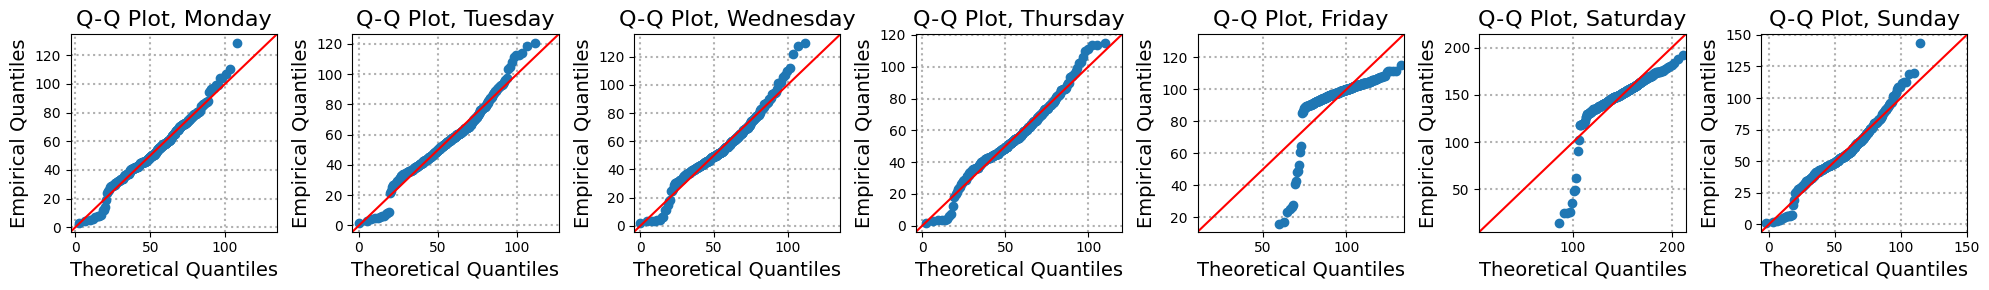

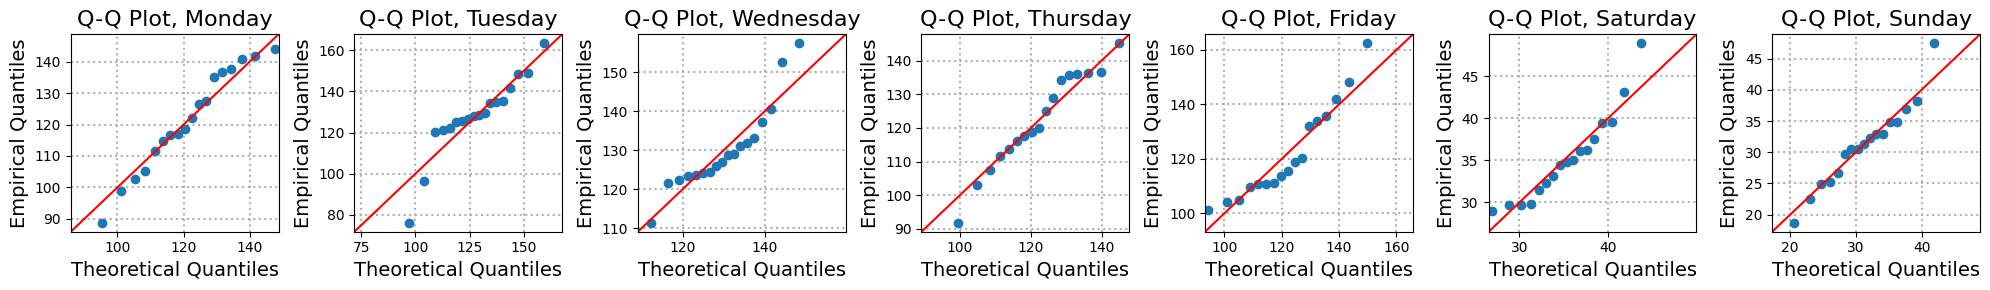

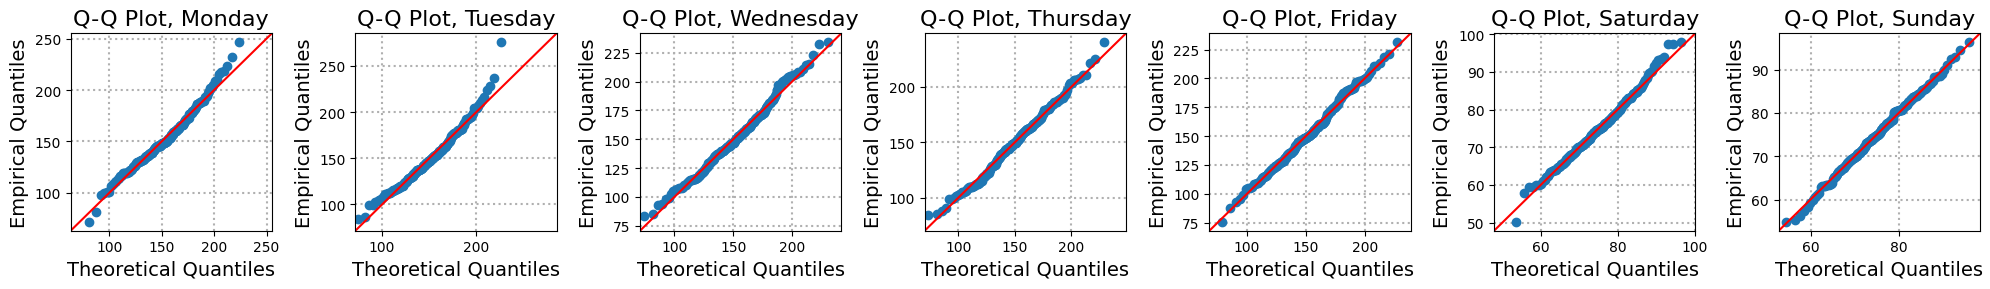

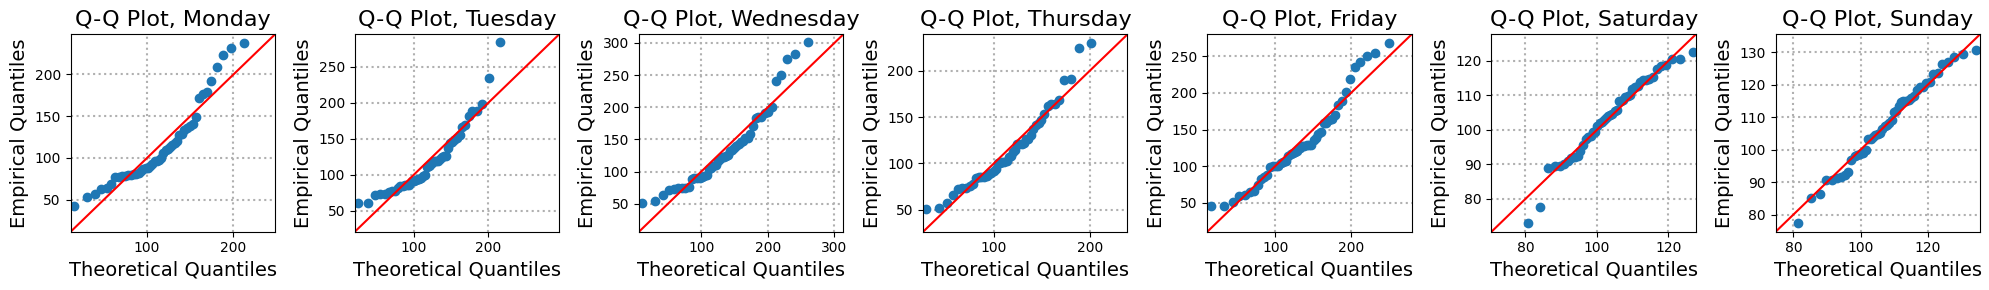

In [5]:
fig, axs = plt.subplots(1, 7, figsize=(20, 3))  # Adjust the figsize as per your preference
for store in stores:
    for i, day in enumerate(daysOfTheWeek):
        data = df[df["weekday_text"] == day][store].dropna()
        plt.sca(axs[i])
        axs[i].cla()

        [me,ve,se,ke] = [sts.describe(data).mean, sts.describe(data).variance,sts.describe(data).skewness,sts.describe(data).kurtosis]       
        sm.qqplot(data, sts.norm(loc=me, scale=np.sqrt(ve)), line='45',ax=axs[i])

        #plt.title("{0}".format(day))
        plt.title('Q-Q Plot, {0}'.format(day), fontsize=16)
        plt.xlabel('Theoretical Quantiles',fontsize=14)
        plt.ylabel('Empirical Quantiles',fontsize=14)
        plt.grid(True,linewidth=1.5,linestyle=':')
        plt.tight_layout()
    plt.show()

QQ-plots for the lognormal distribution

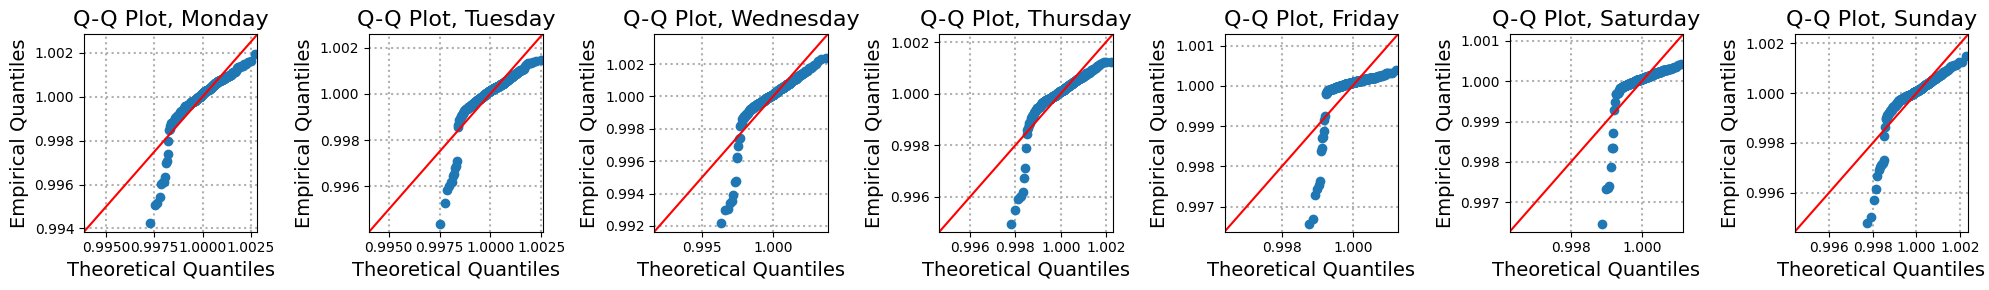

In [11]:
fig, axs = plt.subplots(1, 7, figsize=(20, 3))
#for store in stores:


for i, day in enumerate(daysOfTheWeek):
    #data = np.log(df[df["weekday_text"] == day][store].dropna())
    data = np.log(df[df["weekday_text"] == day]["main street A"].dropna())
    plt.sca(axs[i])
    axs[i].cla()
    [me,ve,se,ke] = [sts.describe(data).mean, sts.describe(data).variance,sts.describe(data).skewness,sts.describe(data).kurtosis]       
    sm.qqplot(data, sts.lognorm, fit=True, line='45',ax=axs[i])
    
    plt.title('Q-Q Plot, {0}'.format(day), fontsize=16)
    plt.xlabel('Theoretical Quantiles',fontsize=14)
    plt.ylabel('Empirical Quantiles',fontsize=14)
    plt.grid(True,linewidth=1.5,linestyle=':')
    plt.tight_layout()
plt.show()